In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import seaborn as sns
import numpy as np
dcolors = plt.cm.tab10.colors
from pathlib import Path
import statsmodels.formula.api as sm
from scipy.stats import linregress


In [122]:
git_folder = Path('../../..')
figure_folder = git_folder / 'Figures'

In [123]:
fn = git_folder / 'data' / 'other'/'A_rates_and_values.csv'
df_rates = pd.read_csv(fn, index_col=0)
# df_rates = df_rates.loc[~df_rates['Rate [mmol/gDW/h]'].isna()]

In [124]:
fn_classification = git_folder / 'data'/'this_project'/'5_div'/'5D_classyfire_classification.csv'
df_classyfire = pd.read_csv(fn_classification, index_col=0)
met_to_class = df_classyfire.set_index('Metabolite')['Defined class'].to_dict()

In [125]:
df_rates['Compound class'] = df_rates.Metabolite.map(met_to_class)

In [126]:
df_rates.rename(columns = {'xlogP': 'log P'}, inplace=True)
df_rates['log10(Intracellular conc. [M])'] = np.log10(df_rates['Intracellular concentration [M]'])


In [127]:
df_rates.replace({'Species': {'Ecoli': 'E. coli', 'Pputida': 'P. putida'}}, inplace=True)

# Simple linear model of E. coli in controlled conditions


In [138]:
df_mean = df_rates.groupby(['Carbon source', 'Species', 'Metabolite', 'Dataset']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
df_mean['Compound class'] = df_mean.Metabolite.map(met_to_class)

df_mean.replace([np.inf, -np.inf], np.nan, inplace=True)

df_mean_ecoli = df_mean.loc[(df_mean.Species=='E. coli')&(df_mean.Dataset != 'Vila-23')].copy()


In [139]:
df_mean_ecoli.dropna(subset=['Rate [mmol/gDW/h]', 'Metabolite value [gDW/mmol]'], inplace=True)


In [140]:
df_mean_ecoli['Compound class'].unique()

array(['Carboxylic acids', 'Amino acids', 'Keto / hydroxy acids', 'Other',
       'Organooxygen compounds'], dtype=object)

In [147]:
key_to_col = {
    'Y':'log10(Rate [mmol/gDW/h])',
    'A':'log10(Intracellular conc. [M])',
    'B':'log10(Metabolite value [gDW/mmol])',
    'C':'Charge',
    'D':'Mol weight [g/mol]',
    'E':'log P',
    'F':'log10(Turnover [mmol/gDW/h])',
    'R':'Rotatable Bond Count',
    'S':'Hydrogen Bond Donor Count',
    'T':'Hydrogen Bond Acceptor Count',
    'U':'Topological Polar Surface Area',
    'G':'Compound class',
    'H':'Carbon source',
    # 'V':'Simplified class',
}
lindf = pd.DataFrame()
lindf['Y'] = df_mean_ecoli['log10(Rate [mmol/gDW/h])']
lindf['A'] = df_mean_ecoli['log10(Intracellular conc. [M])']
lindf['B'] = df_mean_ecoli['log10(Metabolite value [gDW/mmol])']
lindf['C'] = df_mean_ecoli['Charge']
lindf['D'] = df_mean_ecoli['Mol weight [g/mol]']
lindf['E'] = df_mean_ecoli['log P']
lindf['F'] = df_mean_ecoli['log10(Turnover [mmol/gDW/h])'].copy()
lindf['R'] = df_mean_ecoli['Rotatable Bond Count']
lindf['S'] = df_mean_ecoli['Hydrogen Bond Donor Count']
lindf['T'] = df_mean_ecoli['Hydrogen Bond Acceptor Count']
lindf['U'] = df_mean_ecoli['Topological Polar Surface Area']
lindf['G'] = df_mean_ecoli['Compound class']
lindf['H'] = df_mean_ecoli['Carbon source']
lindf['I'] = df_mean_ecoli['Dataset']

# lindf['V'] = lindf.G.map(simplify_class)
lindf.fillna({'F':-4}, inplace = True)

lindf.dropna(inplace=True)

var_explained = {}
for key, col_name in key_to_col.items():
    if col_name == 'log10(Rate [mmol/gDW/h])':
        continue
    if key not in lindf.columns:
        continue
    res = sm.ols(formula=f"Y ~ {key}", data=lindf).fit()
    var_explained[col_name] = res.rsquared
    print(key, col_name, f'R2: {res.rsquared:.2f}')
    # print(res.summary2())


var_explained['log10(MV) + log10(IC) + Charge + C class'] = res.rsquared
print(var_explained)
df_r2 = pd.DataFrame(var_explained, index = ['Variability explained']).T.reset_index(names = 'Parameter').sort_values(by= 'Variability explained', ascending = False)

A log10(Intracellular conc. [M]) R2: 0.05
B log10(Metabolite value [gDW/mmol]) R2: 0.43
C Charge R2: 0.04
D Mol weight [g/mol] R2: 0.11
E log P R2: 0.19
F log10(Turnover [mmol/gDW/h]) R2: 0.04
R Rotatable Bond Count R2: 0.19
S Hydrogen Bond Donor Count R2: 0.18
T Hydrogen Bond Acceptor Count R2: 0.05
U Topological Polar Surface Area R2: 0.05
G Compound class R2: 0.29
H Carbon source R2: 0.04
{'log10(Intracellular conc. [M])': np.float64(0.045299912601014514), 'log10(Metabolite value [gDW/mmol])': np.float64(0.4298784611117007), 'Charge': np.float64(0.03593401599726698), 'Mol weight [g/mol]': np.float64(0.11347823733697782), 'log P': np.float64(0.18731011613421622), 'log10(Turnover [mmol/gDW/h])': np.float64(0.04207654819085538), 'Rotatable Bond Count': np.float64(0.1940986877405484), 'Hydrogen Bond Donor Count': np.float64(0.1786975611653263), 'Hydrogen Bond Acceptor Count': np.float64(0.045831775287176746), 'Topological Polar Surface Area': np.float64(0.053453413238113145), 'Compound 

In [142]:
import scipy.stats as st
st.pearsonr(lindf['B'], lindf['Y'])
st.pearsonr(lindf['B'], lindf['U'])


PearsonRResult(statistic=np.float64(0.32635759866695324), pvalue=np.float64(0.001498779040498903))

log10(Metabolite value [gDW/mmol])
Rotatable Bond Count
log P
Hydrogen Bond Donor Count
Mol weight [g/mol]
Topological Polar Surface Area
Hydrogen Bond Acceptor Count
log10(Intracellular conc. [M])
log10(Turnover [mmol/gDW/h])
Charge


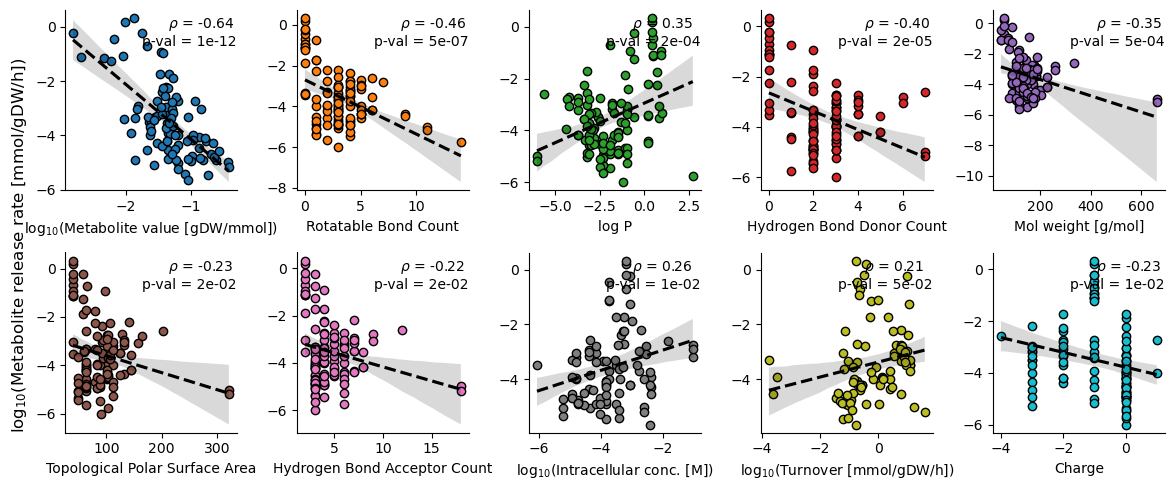

In [153]:

fig, axes = plt.subplots(2,5, figsize = (12,5))#,sharey=True)
axes = axes.flatten()

color_dict = {xaxis:f'C{i}' for i, xaxis in enumerate(df_r2.Parameter)}
bar_colors = [color_dict[x] for x in df_r2.Parameter.values]

number_cols = df_mean.select_dtypes(include='number')
plot_parameters = [x for x in df_r2.Parameter if x in number_cols]

for i, xaxis in enumerate(plot_parameters):
    ax = axes[i]
    print(xaxis)
    idx = (df_mean.Species=='E. coli')&(df_mean.Dataset != 'Vila-23')&df_mean[[xaxis,'log10(Rate [mmol/gDW/h])']].notna().all(axis = 1)

    sns.regplot(data = df_mean.loc[idx], x = xaxis, y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': bar_colors[i], 'edgecolor': 'k', 'alpha':1}, ax = ax)
    ax.set_xlabel(xaxis)
    ax.set_ylabel("")

    slope, intercept, rvalue, pvalue, _ = linregress(df_mean.loc[idx, xaxis].values, df_mean.loc[idx, 'log10(Rate [mmol/gDW/h])'].values)
    ax.annotate(fr'$\rho$ = {rvalue:.2f}', (0.6, 0.9), xycoords = 'axes fraction')
    ax.annotate(fr'p-val = {pvalue:.0e}', (0.45, 0.8), xycoords = 'axes fraction')
    ax.set_xlabel(ax.get_xlabel().replace('log10', r'$\rm{log_{10}}$'),size = 10)
    # ax.annotate(fr'$R^2$ = {rvalue**2:.2f}', (0.62, 0.7), xycoords = 'axes fraction')
    
fig.supylabel(r'$\rm{log_{10}}$(Metabolite release rate [mmol/gDW/h])', size = 12)
# axes[-2].remove()
# axes[-1].remove()
plt.tight_layout()
sns.despine()
plt.savefig(figure_folder/'correlations_different_factors_ecoli_standards.pdf')
# corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])']]
# corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

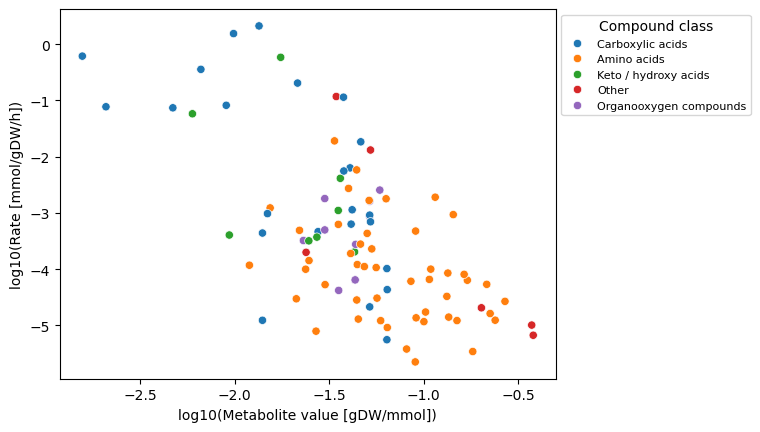

In [145]:
ax = sns.scatterplot(data = df_mean_ecoli, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', hue = 'Compound class')
sns.move_legend(ax, loc  ='upper left', bbox_to_anchor=(1, 1), title = 'Compound class', fontsize = 8)

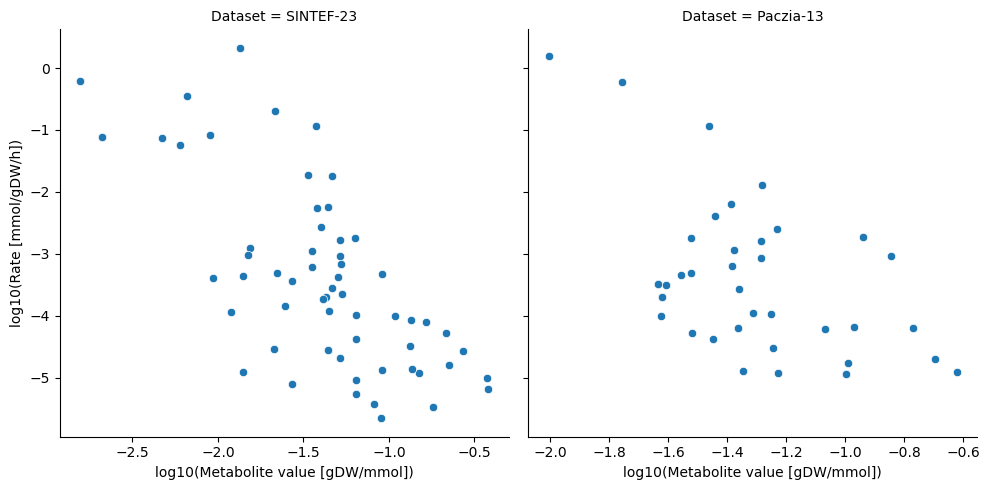

In [146]:
fig = sns.relplot(data = df_mean_ecoli, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Dataset', 
                  facet_kws={'sharey': True, 'sharex': False})
# sns.move_legend(ax, loc  ='upper left', bbox_to_anchor=(1, 1), title = 'Compound class', fontsize = 8)